> Igor Sorochan DSU-31
## Домашнее задание по теме «Рекомендации на основе содержания»


In [80]:
import os
import numpy as np
import pandas as pd


make_dataset.py, clean.py, build_features.py, train_model.py, predict_model.py и evaluate_model.py

In [81]:
def load_data(dir_path: str) -> tuple:
    """Load data from csv files"""
    os.chdir(path=dir_path)
    os.getcwd()
    links = pd.read_csv("links.csv")
    movies = pd.read_csv("movies.csv")
    ratings = pd.read_csv("ratings.csv")
    tags = pd.read_csv("tags.csv")
    return links, movies, ratings, tags

In [82]:
def clean_data(
    links: pd.DataFrame, movies: pd.DataFrame, ratings: pd.DataFrame, tags: pd.DataFrame
) -> tuple:
    """Clean data"""
    # Remove NaN values
    links = links.dropna()
    movies = movies.dropna()
    ratings = ratings.dropna()
    tags = tags.dropna()
    # Remove duplicates
    links = links.drop_duplicates()
    movies = movies.drop_duplicates()
    ratings = ratings.drop_duplicates()
    tags = tags.drop_duplicates()
    return links, movies, ratings, tags

In [83]:
def build_features(
    links: pd.DataFrame, movies: pd.DataFrame, ratings: pd.DataFrame, tags: pd.DataFrame
) -> tuple:
    """Build features"""
    # Create a new feature 'year' from 'title'
    movies["year"] = movies["title"].str.extract(r"(\d{4})")
    movies["genre"] = (
        movies["genres"]
        .str.split("|")
        .apply(lambda lst: " ".join(lst))
    )
    movies.drop(columns=["genres"], inplace=True)
    # Create a new feature 'tag' from 'tag'
    tags["tag"] = (
        tags["tag"].str.split(" ").apply(lambda lst: " ".join(lst))
    )
    tags.drop(columns=["timestamp"], inplace=True)
    return links, movies, ratings, tags

In [84]:
links, movies, ratings, tags = build_features(
    *clean_data(
        *load_data(
            dir_path="/Users/velo1/SynologyDrive/GIT_syno/data/MovieLens _ml-latest-small"
        )
    )
)

In [85]:
print(f"Ratings shape: {ratings.shape}")
print(f"Movies shape: {movies.shape}")
print(f"Tags shape: {tags.shape}")
print(f"Links shape: {links.shape}")

Ratings shape: (100004, 4)
Movies shape: (9125, 4)
Tags shape: (1296, 3)
Links shape: (9112, 3)


## Prediction of the mean rating of the film 

In [86]:
# `Left join` movies.csv and ratings.csv on movieId, delete `timestamp` column.
movie_ratings = movies.join(ratings.set_index("movieId"), on="movieId").drop(
    "timestamp", axis=1
).dropna()
movie_ratings.shape

(100001, 6)

In [87]:
movies_ratings_tags = movie_ratings.join(
    tags.set_index(["movieId"]), on=["movieId"], how="left", rsuffix="_tag"
)#.drop(["userId_tag","userId", "title"], axis=1)

# movies_ratings_tags

In [88]:
# groupby movieId and aggregate tags,ratings and genres per movie
movies_grouped = movies_ratings_tags.groupby(['movieId']).agg({
    # list of aggregations per column (whitespace separated UNIQUE strings)
    'tag': lambda lst: list(set(' '.join(map(str, lst)).replace('nan',"").split(" "))),
    'rating':('mean', 'count'),
    # retrieve the first value of the groupby object
    'title': 'first',
    'year': 'first',
    # list of aggregations per column (whitespace separated UNIQUE strings)
    "genre": lambda lst: list(set(' '.join(map(str, lst)).split(" ")))
    }).sort_values(by= ('rating','count'),ascending=False)
print(movies_grouped.shape)
# set new column names
movies_grouped.columns = ['tag', 'rating_mean', 'rating_count', 'title', 'year', 'genre']
# convert year to int
movies_grouped['year'] = movies_grouped['year'].astype(int)
# convert genre list to string
movies_grouped["genre"] = movies_grouped["genre"].apply(lambda x: ' '.join(x) )
# convert tag list to string
movies_grouped["tag"] = movies_grouped["tag"].apply(lambda x: ' '.join(x) )

# movies_grouped.head(10)

(9063, 6)


In [89]:
movies_grouped[['tag', 'rating_mean', 'rating_count', 'year', 'genre']]

,tag,rating_mean,rating_count,year,genre
movieId,,,,,
260,classic script space sci-fi coming soundtrack ...,4.221649,7275,1977,Action Sci-Fi Adventure
318,Morgan Tim Robbins wrongful revenge escape fri...,4.487138,2799,1994,Drama Crime
1210,aliens sequel Lucas war Harrison space Wars Ge...,4.059908,2170,1983,Action Sci-Fi Adventure
47,violent greed disturbing crime killer horror e...,4.034826,2010,1995,Thriller Mystery
1265,Bill character reality feel-good self existent...,3.839394,1650,1993,Comedy Fantasy Romance
...,...,...,...,...,...
5356,,0.500000,1,1975,Horror Sci-Fi
54220,,4.000000,1,1969,Comedy Drama
54251,,5.000000,1,2004,Comedy


In [90]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import mean_squared_error
import scipy.sparse as sp

In [91]:
# lr = ridge_regression()
tags_tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), min_df=0, stop_words='english'
                        , max_features=10000)

genres_tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), min_df=0, stop_words='english'
                        , max_features=10000)

scaled = Normalizer().fit(X=movies_grouped[[ 'year','rating_count']])

tfidf = sp.hstack((tags_tfidf.fit_transform(movies_grouped['tag']), genres_tfidf.fit_transform(movies_grouped['genre'])))
# tfidf_scaled = sp.hstack((tfidf, scaled.fit_transform(X=movies_grouped[[ 'year']], y=movies_grouped['rating_mean'])))
tfidf_scaled = sp.hstack((tfidf, scaled.transform(X=movies_grouped[[ 'year','rating_count']])))
tfidf_scaled

<9063x720 sparse matrix of type '<class 'numpy.float64'>'
	with 40907 stored elements in COOrdinate format>

In [92]:
print(len(genres_tfidf.get_feature_names_out()))
genres_tfidf.get_feature_names_out()

23


array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'fi', 'film', 'genres',
       'horror', 'imax', 'listed', 'musical', 'mystery', 'noir',
       'romance', 'sci', 'thriller', 'war', 'western'], dtype=object)

In [93]:
cols = np.hstack(
    (tags_tfidf.get_feature_names_out().reshape(1, -1),
     genres_tfidf.get_feature_names_out().reshape(1, -1),
     scaled.get_feature_names_out().reshape(1, -1)
    )
)
pd.DataFrame(tfidf_scaled.toarray(), columns=cols[0])

,1940,80,abigail,acclaimed,accurate,acting,action,activist,adam,adaptation,...,musical,mystery,noir,romance,sci,thriller,war,western,year,rating_count
0,0.0,0.0,0.0,0.1678,0.0,0.0,0.148228,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.00000,0.537661,0.000000,0.0,0.0,0.262242,0.965002
1,0.0,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.580219,0.814460
2,0.0,0.0,0.0,0.0000,0.0,0.0,0.243214,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.00000,0.537661,0.000000,0.0,0.0,0.674584,0.738198
3,0.0,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.82062,0.0,0.00000,0.000000,0.571474,0.0,0.0,0.704454,0.709750
4,0.0,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.55557,0.000000,0.000000,0.0,0.0,0.770276,0.637710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9058,0.0,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.00000,0.582801,0.000000,0.0,0.0,1.000000,0.000506
9059,0.0,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.00000,0.000000,0.000000,0.0,0.0,1.000000,0.000508
9060,0.0,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.00000,0.000000,0.000000,0.0,0.0,1.000000,0.000499
9061,0.0,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.00000,0.000000,0.000000,0.0,0.0,1.000000,0.000507


In [96]:
X_train, X_test, y_train, y_test = train_test_split(
    tfidf_scaled,
    movies_grouped["rating_mean"],
    test_size=0.2,
    random_state=42,
)
rr = Ridge(alpha=5)
rr.fit(X_train, y_train)
y_pred = rr.predict(X_test)
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")

RMSE: 0.8557787481583491


In [99]:
results = pd.DataFrame({'y_pred':y_pred, 'y_test':y_test})
results['delta'] = results['y_pred'] - results['y_test']
results.sample(10).style.background_gradient(subset=['delta'], cmap='coolwarm').format("{:.2f}")

,y_pred,y_test,delta
movieId,,,
4151,3.37,4.50,-1.13
522,3.15,2.83,0.31
786,3.15,3.11,0.04
128360,3.70,4.06,-0.36
3143,3.57,4.00,-0.43
51884,3.43,3.00,0.43
118334,3.15,2.00,1.15
3669,3.06,2.67,0.39
99030,3.38,5.00,-1.62


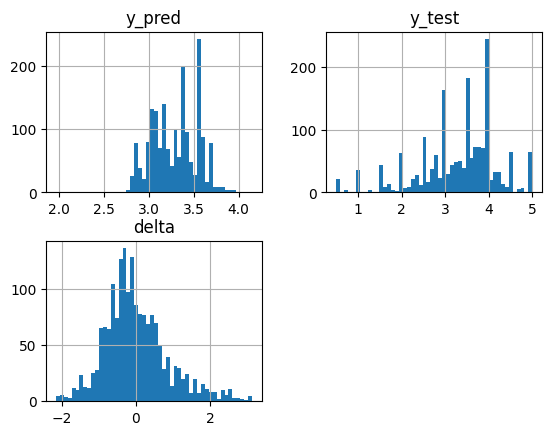

In [19]:
results.hist(bins=50);

Errors are almost evenly distributed.  



In [100]:
def random_predict(feat_num: int, X_test: np.array, cols:np.array, regressor: object) -> np.array:
    test_data = np.zeros((cols.shape))
    indices = np.random.choice(test_data.size, feat_num, replace=False)
    test_data.flat[indices] = 1

    return [cols[test_data.astype(bool)], regressor.predict(test_data)]

In [101]:
# Let's find three sets of only 7 tags and genres with rating higher than 4.5. 
counter = 0
while True:
    inp = random_predict(6, X_test, cols, rr)
    if inp[1] > 4.5:
        counter += 1
        print(pd.DataFrame(np.hstack((inp[0],inp[1]))))
        if counter > 2:
            break


              0
0        boring
1        easily
2          jude
3     toplist10
4         woman
5  rating_count
6      5.063093
              0
0        acting
1         bloom
2          cute
3         firth
4         zooey
5  rating_count
6      4.705338
              0
0      feminist
1       musical
2       orlando
3         tales
4         woman
5  rating_count
6      4.819026


In [102]:
# Let's find three sets of only 7 tags and genres with rating lower than 2.5. 
counter = 0
while True:
    inp = random_predict(6, X_test, cols, rr)
    if inp[1] < 2.5:
        counter += 1
        print(pd.DataFrame(np.hstack((inp[0],inp[1]))))
        if counter > 2:
            break

             0
0     activist
1       cusack
2  intelligent
3     presence
4       stupid
5     children
6     2.384649
          0
0  baseball
1  disorder
2   maguire
3    stupid
4    action
5    horror
6  2.456113
          0
0   episode
1      hugh
2   physics
3     tosee
4    action
5  children
6  2.497534


## Prediction of the user ratings for the film

In [103]:
tags

,userId,movieId,tag
0,15,339,sandra 'boring' bullock
1,15,1955,dentist
2,15,7478,Cambodia
3,15,32892,Russian
4,15,34162,forgettable
...,...,...,...
1291,660,135518,meaning of life
1292,660,135518,philosophical
1293,660,135518,sci-fi
1294,663,260,action


In [114]:
users_ratings_tags = movie_ratings.join(
    tags.set_index(["userId","movieId"]), on=["userId","movieId"], how="left", rsuffix="_tag"
)#.drop(["movieId_tag","userId", "title"], axis=1)

users_ratings_tags

,movieId,title,year,genre,userId,rating,tag
0,1,Toy Story (1995),1995,Adventure Animation Children Comedy Fantasy,7.0,3.0,NaN
0,1,Toy Story (1995),1995,Adventure Animation Children Comedy Fantasy,9.0,4.0,NaN
0,1,Toy Story (1995),1995,Adventure Animation Children Comedy Fantasy,13.0,5.0,NaN
0,1,Toy Story (1995),1995,Adventure Animation Children Comedy Fantasy,15.0,2.0,NaN
0,1,Toy Story (1995),1995,Adventure Animation Children Comedy Fantasy,19.0,3.0,NaN
...,...,...,...,...,...,...,...
9116,161918,Sharknado 4: The 4th Awakens (2016),2016,Action Adventure Horror Sci-Fi,624.0,1.5,NaN
9117,161944,The Last Brickmaker in America (2001),2001,Drama,287.0,5.0,NaN
9119,162542,Rustom (2016),2016,Romance Thriller,611.0,5.0,NaN
9120,162672,Mohenjo Daro (2016),2016,Adventure Drama Romance,611.0,3.0,NaN


In [105]:
# groupby movieId and aggregate tags,ratings and genres per movie
users_grouped = users_ratings_tags.groupby(['userId']).agg({
    # list of aggregations per column (whitespace separated UNIQUE strings)
    'tag': lambda lst: list(set(' '.join(map(str, lst)).replace('nan',"").split(" "))),
    'rating':('mean', 'count'),
    # retrieve the first value of the groupby object
    'title': lambda lst: " ".join(map(str, lst)),
    'year': lambda lst: list(set(' '.join(map(str, lst)).replace('nan',"").split(" "))),
    # list of aggregations per column (whitespace separated UNIQUE strings)
    "genre": lambda lst: list(set(' '.join(map(str, lst)).split(" ")))
    }).sort_values(by= ('rating','count'),ascending=False)
print(users_grouped.shape)
# set new column names
users_grouped.columns = ['tag', 'rating_mean', 'rating_count', 'title', 'year', 'genre']
# convert year to int
users_grouped['year'] = users_grouped['year'].apply(lambda x: ' '.join(x) )
# convert genre list to string
users_grouped["genre"] = users_grouped["genre"].apply(lambda x: ' '.join(x) )
# convert tag list to string
users_grouped["tag"] = users_grouped["tag"].apply(lambda x: ' '.join(x) )

# users_grouped.sample(10)

(671, 6)


In [115]:
users_grouped[['tag', 'rating_mean', 'rating_count', 'year', 'genre']]

,tag,rating_mean,rating_count,year,genre
userId,,,,,
547.0,toplist13 toplist16 toplist11 afi toplist05 t...,3.366318,2390,1926 1981 2007 1958 1939 1967 1931 1935 1955 1...,genres Western Sci-Fi Animation Drama IMAX Chi...
564.0,,3.552463,1868,1948 1938 1953 1981 1991 1978 1959 1933 1958 1...,Western Sci-Fi Animation Drama IMAX Children W...
624.0,,2.894752,1734,1981 2007 1939 1967 1935 1955 1989 2006 1987 1...,genres Western Sci-Fi Animation Drama IMAX Chi...
15.0,forgettable dentist story activist dull ugand...,2.621622,1702,1981 2007 1958 1939 1967 1931 1935 1989 1946 1...,Western Sci-Fi Animation Drama IMAX Children W...
73.0,b kung indie anime drama love horror action m...,3.373994,1615,1948 2004 1938 1953 1981 1991 1978 1959 2007 1...,genres Western Sci-Fi Animation Drama IMAX Chi...
...,...,...,...,...,...
289.0,,3.675000,20,1997 2003 2004 2000 1968 1986 1996 1981 1991 1...,Children Drama Mystery Thriller Fantasy Romanc...
249.0,,3.600000,20,1990 1991 1993 1994 1995,Drama Thriller Fantasy Romance Horror War Adve...
221.0,,2.775000,20,1997 1998 1990 1984 2000 1986 1996 1978 1993 1...,Drama Thriller Fantasy Romance Horror War Adve...


In [116]:
# let's check userId 15
users_grouped.loc[15]

tag              forgettable dentist story activist dull ugand...
rating_mean                                              2.621622
rating_count                                                 1702
title           Toy Story (1995) Jumanji (1995) Father of the ...
year            1981 2007 1958 1939 1967 1931 1935 1989 1946 1...
genre           Western Sci-Fi Animation Drama IMAX Children W...
Name: 15.0, dtype: object

In [117]:
# lr = ridge_regression()
tags_tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), min_df=0, stop_words='english'
                        , max_features=10000)

genres_tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), min_df=0, stop_words='english'
                        , max_features=10000)

tfidf = sp.hstack((tags_tfidf.fit_transform(users_grouped['tag']), genres_tfidf.fit_transform(users_grouped['genre'])))

tfidf

<671x662 sparse matrix of type '<class 'numpy.float64'>'
	with 12935 stored elements in Compressed Sparse Row format>

In [118]:
cols = np.hstack(
    (tags_tfidf.get_feature_names_out().reshape(1, -1),
     genres_tfidf.get_feature_names_out().reshape(1, -1)
    )
)
pd.DataFrame(tfidf.toarray(), columns=cols[0])

,1940,80,abigail,accurate,acting,action,activist,adam,adaptation,adapted,...,imax,listed,musical,mystery,noir,romance,sci,thriller,war,western
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.157109,0.541941,0.135256,0.120136,0.212055,0.113526,0.114034,0.113189,0.125266,0.154894
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.244589,0.000000,0.210569,0.187029,0.330130,0.176739,0.177530,0.176214,0.195016,0.241140
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.157109,0.541941,0.135256,0.120136,0.212055,0.113526,0.114034,0.113189,0.125266,0.154894
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.300329,0.0,0.0,0.0,...,0.244589,0.000000,0.210569,0.187029,0.330130,0.176739,0.177530,0.176214,0.195016,0.241140
4,0.0,0.0,0.0,0.0,0.0,0.305252,0.000000,0.0,0.0,0.0,...,0.157109,0.541941,0.135256,0.120136,0.212055,0.113526,0.114034,0.113189,0.125266,0.154894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.286180,0.254188,0.000000,0.240203,0.000000,0.239489,0.265043,0.327729
667,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.263949,0.265130,0.263165,0.291245,0.360129
668,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.299988,0.000000,0.000000,0.251792,0.252919,0.251044,0.277831,0.343542
669,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.289875,0.257469,0.000000,0.243304,0.244392,0.242581,0.268465,0.331960


In [123]:
X_train, X_test, y_train, y_test = train_test_split(
    tfidf,
    users_grouped["rating_mean"],
    test_size=0.2,
    random_state=42,
)
rr = Ridge(alpha=1)

rr.fit(X_train, y_train)
y_pred = rr.predict(X_test)
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")

RMSE: 0.4314061176418142


In [124]:
results = pd.DataFrame({'y_pred':y_pred, 'y_test':y_test})
results['delta'] = results['y_pred'] - results['y_test']
results.sample(10).style.background_gradient(subset=['delta'], cmap='coolwarm').format("{:.2f}")

,y_pred,y_test,delta
userId,,,
415.000000,3.73,4.00,-0.27
650.000000,3.52,3.31,0.21
52.000000,3.75,3.69,0.06
17.000000,3.71,3.74,-0.03
29.000000,3.81,2.86,0.95
468.000000,3.72,2.97,0.76
387.000000,3.59,4.21,-0.62
291.000000,3.63,4.23,-0.60
438.000000,3.79,4.38,-0.58


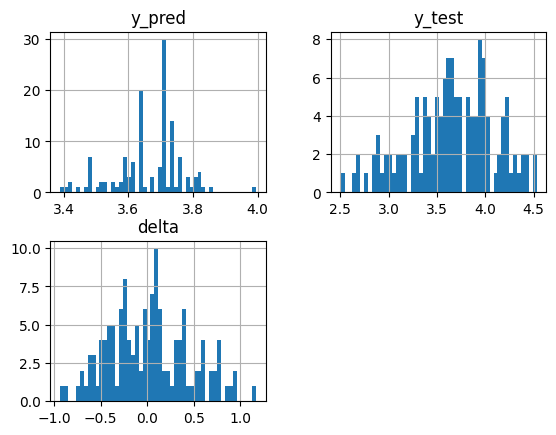

In [125]:
results.hist(bins=50);

### Main takeaways:
### It's much easier to predict user ratings than mean film rating given the tages and genres.